# GEONE - GEOSCLASSIC - Examples in 3D with non-stationary covariance model

Examples of estimation and simulation for a continuous variable in a 3D grid, based on simple and ordinary kriging, and with a non-stationary covariance model are proposed.

**Remark:** for details explanations about estimation and simulation, see jupyter notebook `ex_geosclassic_3d_1.ipynb`.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.17


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Launching simulation and estimation in 3D
The following functions are used:

- `geone.geosclassicinterface.simulate3D[_mp]` for simulation 3D (sequential Gaussian simulation, SGS)
- `geone.geosclassicinterface.estimate3D` for estimation 3D (kriging estimates and standard deviation)

**Alternatives**

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments

- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate<d>D[_mp]`
- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate<d>D`

where the dimension `<d>` is automatically detected.

See jupyter notebook `ex_geosclassic_3d.ipynb` for details.

## Simulation grid
The grid should be defined before defining the non-stationary covariance model.

In [4]:
nx, ny, nz = 85, 56, 34  # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

## Define a non-stationary covariance model in 3D: class `geone.covModel.covModel3D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

Orientation is given by azimuth (`alpha`), dip (`beta`) and plunge (`gamma`) angles in degrees: the coordinates system Ox'''y''''z''', supporting the axes of the model (ranges), is obtained from the original coordinates system Oxyz as follows:

- Oxyz       -> rotation of angle -alpha around Oz   -> Ox'y'z'
- Ox'y'z'    -> rotation of angle -beta  around Ox'  -> Ox''y''z''
- Ox''y''z'' -> rotation of angle -gamma around Oy'' -> Ox'''y'''z'''
    
The parameters of each elementary contribution and the angles `alpha`, `beta`, `gamma` can be set to a `numpy array` with values attached to the simulation grid. Hence, the size of the array and the number of grid cells must match (the array is reshaped if needed). In this way a non-stationary covariance model can be defined.

**Remark:** some functionalities such as getting the sill, range, or plotting the model are not available for non-stationary covariance model.

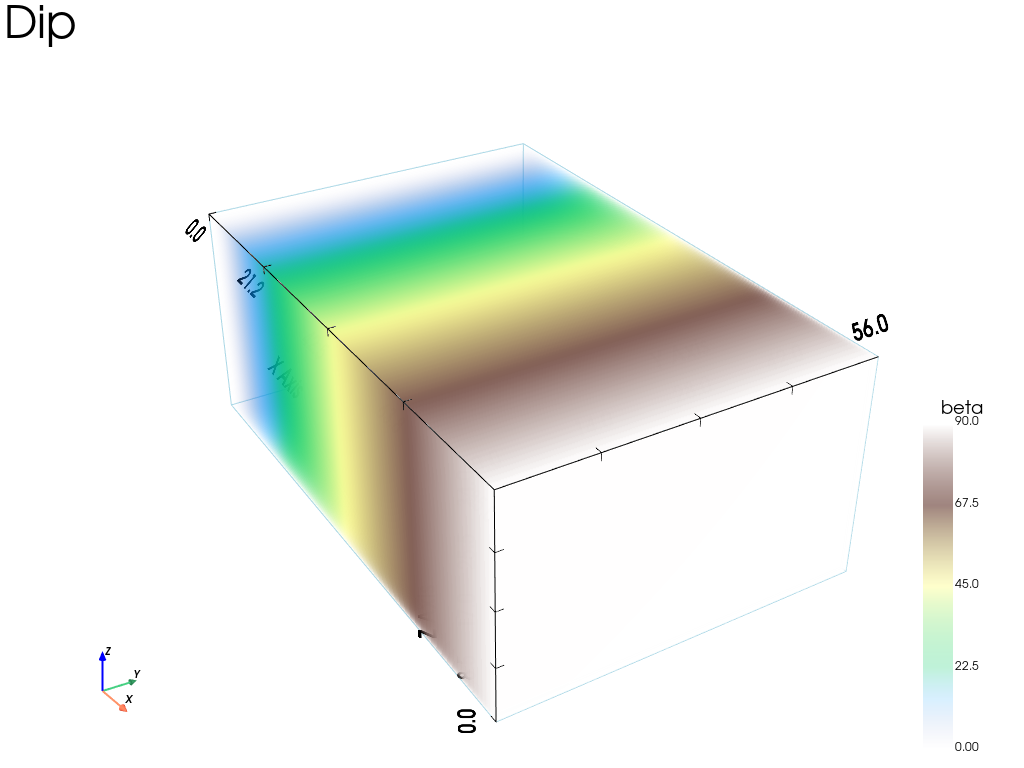

In [5]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x, y, z coordinates of the centers of grid cell (meshgrid)
xx = im.xx()
yy = im.yy()
zz = im.zz()

# Define dip angle over the simulation grid
beta = 0 + (xx-xx.min())/(xx.max()-xx.min())*90.

# Set variable beta image im
im.append_var(beta, varname='beta')

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

gn.imgplot3d.drawImage3D_volume(
    im, 
    plotter=pp,
    cmap='terrain',
    text='Dip',
    show_bounds=True,
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [6]:
# Define the non-stationary covariance model 
cov_model = gn.covModel.CovModel3D(elem=[
    ('spherical', {'w':8.9, 'r':[10, 40, 10]}), # elementary contribution
    ('nugget', {'w':0.1})                      # elementary contribution
    ], alpha=90, beta=beta, gamma=0, name='model-3D example')

### Conditional simulations (hard data)
#### Function `geone.geosclassicinterface.simulate3D[_mp]` or `geone.multiGaussian.multiGaussianRun`

Define hard data. Note that the data points are aggregated in (centers of) grid cells, according to the parameter `aggregate_data_op`; if the covariance model has non-stationary range or weight (sill), then `aggregate_data_op='krige'`, `aggregate_data_op='sgs'` cannot be used.

In [7]:
x = np.array([[ 10.5,  20.5,  3.5], # 1st point
              [ 40.5,  10.5, 10.5], # 2nd point
              [ 30.5,  40.5, 20.5], # 3rd point
              [ 30.5,  30.5, 30.5]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

In [8]:
# Simulation
nreal = 50
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate3D_mp(cov_model, dimension, spacing, origin, 
                                                           x=x, v=v, method='simple_kriging', nreal=nreal,
                                                           nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simulate3D_mp: Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
simulate3D_mp: Geos-Classic run complete (all process(es))
simulate3D_mp: warnings encountered (24 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
Elapsed time: 10 sec


In [9]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

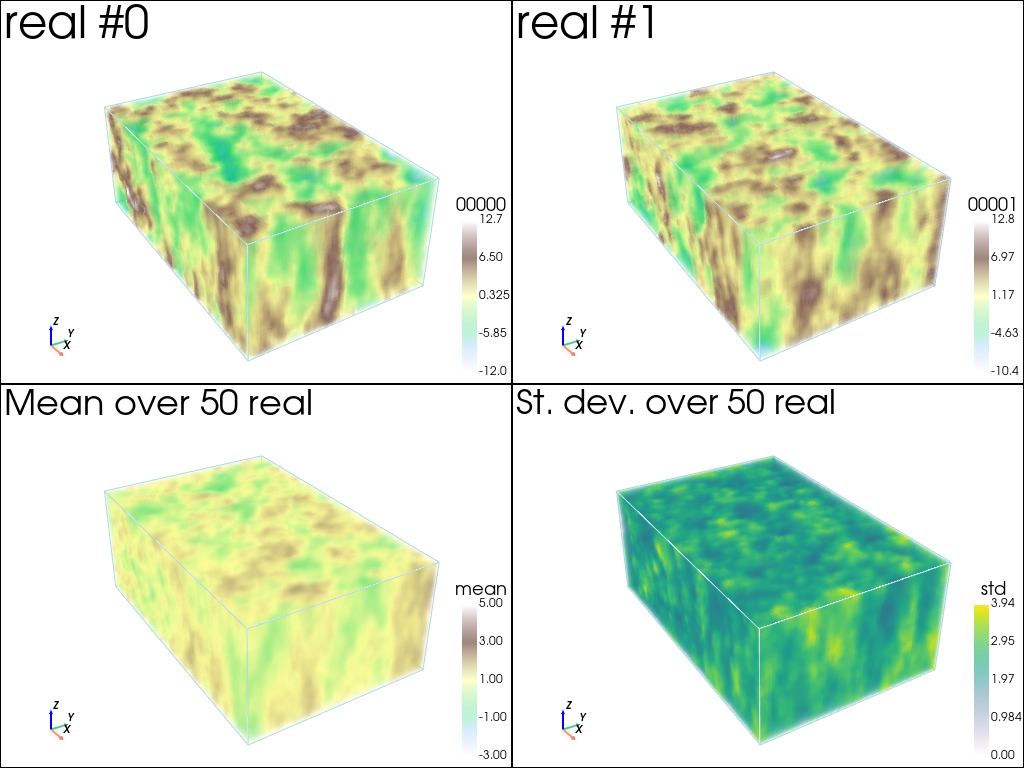

In [10]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(
        simul, iv=i, 
        plotter=pp,
        cmap=cmap,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    simul_mean, 
    plotter=pp,
    cmap=cmap,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_std, 
    plotter=pp,
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

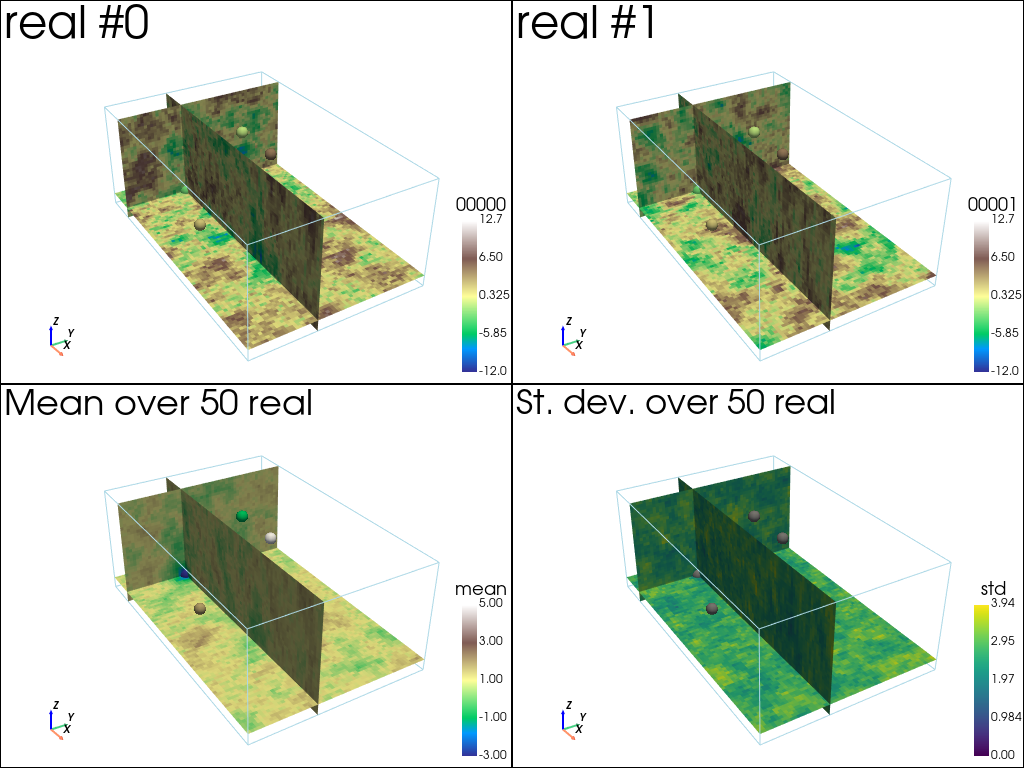

In [11]:
# Color settings
cmap = 'terrain'

cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1

cmin_mean = simul_mean.vmin()[0] # min value for mean
cmax_mean = simul_mean.vmax()[0] # max value for mean

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_mean, cmax=cmax_mean) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

data_points_mean = pv.PolyData(x)
data_points_mean['colors'] = data_points_mean_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul, iv=i, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin, cmax=cmax,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    simul_mean, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_std, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Estimation: kriging estimates and standard deviation
#### Function `geone.geosclassicinterface.estimate3D`
*Note:* unique search neighorhood can not be used with a non-stationary covariance model.

Extract random points from the first realization to set conditioning data.

In [12]:
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=simul.val[0])
n = 140 # number of points
# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im, n, seed=234)
# # Data points and data value
# new_x = np.array((ps.x(), ps.y())).T
# new_v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# new_x[:, 0] = new_x[:, 0] + (np.random.random(n)-0.5)* im.sx
# new_x[:, 1] = new_x[:, 1] + (np.random.random(n)-0.5)* im.sy
# new_x[:, 2] = new_x[:, 2] + (np.random.random(n)-0.5)* im.sz
# new_v = new_v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im)
np.random.seed(658)
x1 = im.xmin() + np.random.random(n) * (im.xmax()-im.xmin())
x2 = im.ymin() + np.random.random(n) * (im.ymax()-im.ymin())
x3 = im.zmin() + np.random.random(n) * (im.zmax()-im.zmin())
new_x = np.array((x1, x2, x3)).T  # location of conditioning data
new_v = f(new_x)                  # location of conditioning data
# ----- #


In [13]:
# Increase searchRadiusRelative to avoid "discontinuities"
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
                                                        x=new_x, v=new_v, method='simple_kriging',
                                                        searchRadiusRelative=2.0,
                                                        nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

estimate3D: Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
estimate3D: Geos-Classic run complete
estimate3D: warnings encountered (324 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  2: WARNING 02015: solving kriging system fails (do as if no neighbor)
Elapsed time: 5.7 sec


In [14]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

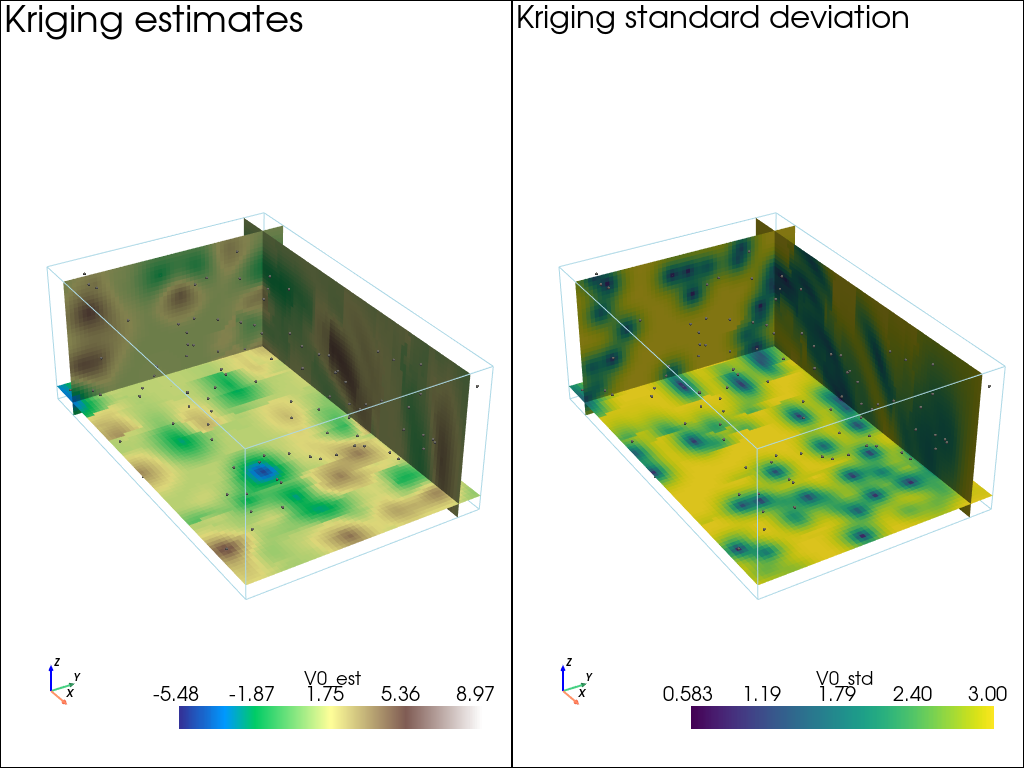

In [15]:
# Color settings
cmap = 'terrain'

cmin = estim.vmin()[0] # min value for krig. est.
cmax = estim.vmax()[0] # max value for krig. est.

# Set points to be plotted
data_points = pv.PolyData(new_x)

# coordinate for othogonal slices
cx, cy, cz = im.ox+0.1*im.nx*im.sx, im.oy+0.9*im.ny*im.sy, im.oz+0.1*im.nz*im.sz

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))
# kriging estimates
pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(
    estim, iv=0, 
    plotter=pp,
    slice_normal_x=cx,
    slice_normal_y=cy,
    slice_normal_z=cz,
    cmap=cmap, cmin=cmin, cmax=cmax, 
    text='Kriging estimates',
    scalar_bar_kwargs={'label_font_size':20})
pp.add_mesh(data_points, color='gray', point_size=3., render_points_as_spheres=True)

# kriging standard deviation
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    estim, iv=1, 
    plotter=pp,
    slice_normal_x=cx,
    slice_normal_y=cy,
    slice_normal_z=cz,
    cmap='viridis', 
    text='Kriging standard deviation',
    scalar_bar_kwargs={'label_font_size':20})
pp.add_mesh(data_points, color='gray', point_size=3., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Conditioning with inequality data (simulation only)

Simulation can be done with usual hard data and inequality data consisting in a lower and/or upper bound at some points.

The conditioning locations with inequality data are first simulated (with truncated gaussian distribution) sequentially. Then, these locations are re-simulated following a new path as many times as needed (Gibbs sampler); the total number of paths will be between `nGibbsSamplerPathMin` and `nGibbsSamplerPathMax` (keyword arguments, default: 50 and 200 respectively).

Define hard data and inequality data with minimal value and inequality with maximal value. Note that the conditioning values (hard, min. or max.) will be attached to the grid cells containing the corresponding conditioning locations.

In [16]:
# Hard data
x = np.array([[ 10.25,  20.14,  3.15], # 1st point
              [ 40.45,  10.82, 10.24], # 2nd point
              [ 30.65,  40.53, 20.24], # 3rd point
              [ 30.18,  30.14, 30.98]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

# Inequality data
xIneqMin = np.array([[ 10.25,  10.35,  6.51],   # 1st point
                     [ 50.15,  20.35, 20.85]])  # 2nd point
vIneqMin = [4., -2.2]  # lower bounds

xIneqMax = np.array([[ 65.54,   5.12,  3.97],   # 1st point
                     [ 50.23,  20.41, 20.86]])  # 2nd point
vIneqMax = [-4.1, -2.]  # upper bounds
# Note: second inequality data point has a lower bound and an upper bound

In [17]:
nreal = 50
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate3D_mp(cov_model, dimension, spacing, origin, 
                                                           x=x, v=v, 
                                                           xIneqMin=xIneqMin, vIneqMin=vIneqMin,
                                                           xIneqMax=xIneqMax, vIneqMax=vIneqMax,
                                                           method='simple_kriging', nreal=nreal,
                                                           nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

simulate3D_mp: Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
simulate3D_mp: Geos-Classic run complete (all process(es))
simulate3D_mp: warnings encountered (19 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
Elapsed time: 17 sec


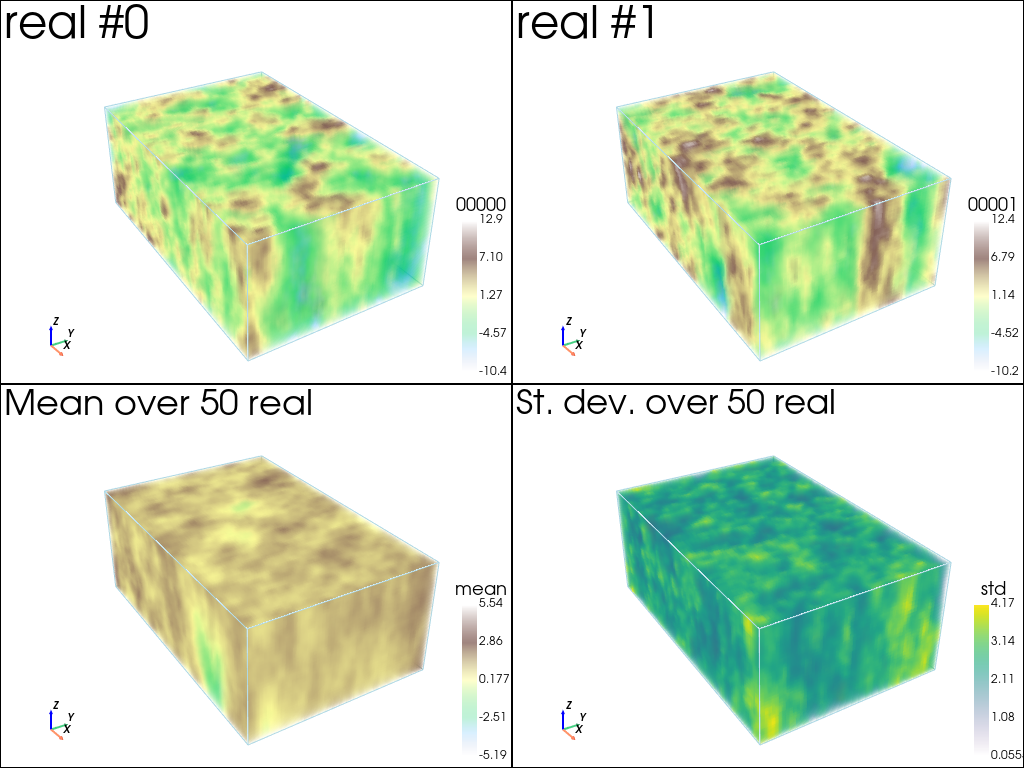

In [18]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(
        simul, iv=i, 
        plotter=pp,
        cmap=cmap,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    simul_mean, 
    plotter=pp,
    cmap=cmap,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_std, 
    plotter=pp,
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

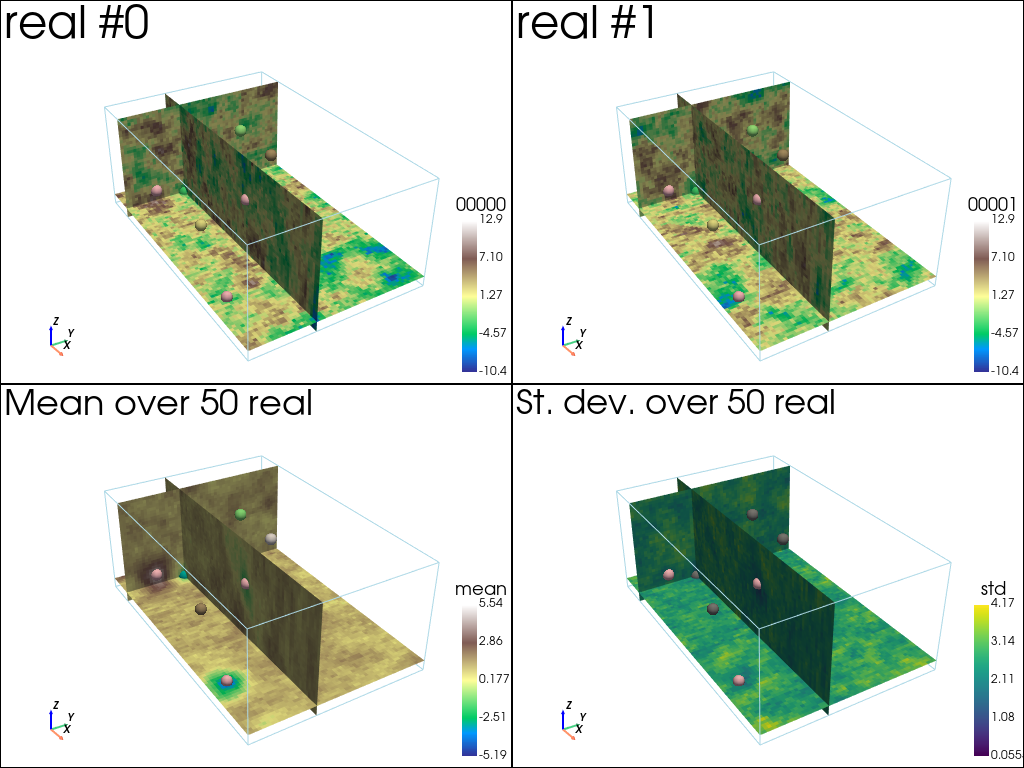

In [19]:
# Color settings
cmap = 'terrain'

cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1

cmin_mean = simul_mean.vmin()[0] # min value for mean
cmax_mean = simul_mean.vmax()[0] # max value for mean

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_mean, cmax=cmax_mean) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

data_points_mean = pv.PolyData(x)
data_points_mean['colors'] = data_points_mean_col

data_points_ineq_min = pv.PolyData(xIneqMin)
data_points_ineq_max = pv.PolyData(xIneqMax)

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul, iv=i, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin, cmax=cmax,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)
    pp.add_mesh(data_points_ineq_min, color='pink', point_size=12., render_points_as_spheres=True)
    pp.add_mesh(data_points_ineq_max, color='pink', point_size=12., render_points_as_spheres=True)

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    simul_mean, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_min, color='pink', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_max, color='pink', point_size=12., render_points_as_spheres=True)

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_std, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_min, color='pink', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_max, color='pink', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Check that conditioning data are honoured

In [20]:
# Compute min and max (pixel-wise)
simul_min = gn.img.imageContStat(simul, op='min')
simul_max = gn.img.imageContStat(simul, op='max')

# Get index of conditioning location in simulation grid
hd_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]
ineqMin_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in xIneqMin]
ineqMax_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in xIneqMax]

# Min and max value at hard data
min_value_at_hd = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
max_value_at_hd = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
print('Hard data value:\n{}'.format(v))
print('Min and max value at hard data:\n{}\n{}'.format(
    min_value_at_hd, max_value_at_hd))
print('Hard data, abs error max: {}\n'.format(max(np.ptp(min_value_at_hd - v), np.ptp(max_value_at_hd - v))))
      
# Min and max value at inequality data with minimal value
min_value_at_ineqMin = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
max_value_at_ineqMin = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
print('Minimal data value:\n{}'.format(vIneqMin))
print('Min and max value at inequality data with minimal value:\n{}\n{}'.format(
    min_value_at_ineqMin, max_value_at_ineqMin))
print('All min data value honoured ? {}\n'.format(np.all(min_value_at_ineqMin > vIneqMin)))

# Min and max value at inequality data with maximal value
min_value_at_ineqMax = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
max_value_at_ineqMax = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
print('Maximal data value:\n{}'.format(vIneqMax))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMax, max_value_at_ineqMax))
print('All max data value honoured ? {}'.format(np.all(max_value_at_ineqMax < vIneqMax)))

Hard data value:
[-3.0, 2.0, 5.0, -1.0]
Min and max value at hard data:
[-4.80174609 -0.40010746  2.33046473 -4.19471729]
[0.91117054 4.49161857 6.58610923 1.99499918]
Hard data, abs error max: 2.3250613106447626

Minimal data value:
[4.0, -2.2]
Min and max value at inequality data with minimal value:
[ 4.11734193 -2.18613201]
[ 8.52349108 -2.00436374]
All min data value honoured ? True

Maximal data value:
[-4.1, -2.0]
Min and max value at inequality data with maximal value:
[-7.54870759 -2.18613201]
[-4.13045709 -2.00436374]
All max data value honoured ? True
